In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import open3d as o3d
import copy

from utils import *

In [3]:
xml_dir = "/home/yunzhu/Documents/project_phystouch/phystouch/data_recording/data"
xml_dir = "C:/Users/lucas/Desktop/UPC/MIT/tactile2object/intrinsics_extrinsics/data/"

cameras = ["020122061233", "821312060044", "020122061651", "821312062243"]

intrinsics = Intrinsics(xml_dir)
extrinsics = Extrinsics(xml_dir)
rgbds = RGBD(xml_dir, recording="recording_wAprilTag/20210714_002709/")
stiched_pcd = Stitching_pcds(intrinsics, extrinsics, rgbds, cameras)


# apriltag

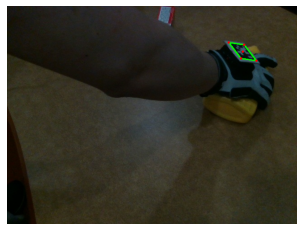

In [16]:
apriltags = AprilTags(intrinsics, xml_dir, recording="recording_wAprilTag/20210714_002709/", cameras=cameras)
apriltags.image(idx="000550", camera="020122061233")

In [5]:
apriltags.corners(idx="000573", camera="020122061233")

(array([[400, 131],
        [409, 185],
        [456, 169],
        [450, 116]]),
 '020122061233')

# PCD
``save_view_point`` will save the view point position when closing.

In [6]:
pcd = stiched_pcd["000557"]
world_coordinates = WorldCoordinates(pcd, cameras)

#save_view_point(pcd)
#load_view_point(pcd)

In [7]:
world_coordinates.from_camera_pixel("020122061233", u=400, v=131)

array([ 0.04416678, -0.05550768,  0.301     ])

# PCD + Corners

In [20]:
# Corner pixels
corners_p, camera = apriltags.corners(idx="000557", camera="020122061233")
# Corners world
corners_w = world_coordinates.from_corners(corners_p, camera)

In [9]:
corners_balls = get_balls_from_corners(corners_w)

vis = [pcd] + corners_balls

# load_view_point(vis)

# Save

In [13]:
save_dir = os.path.join(apriltags.recording_dir, "pcds")

if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
for i in range(58, 600):
    idx = str(i).zfill(6)
    
    # Stiched point cloud from all the cameras
    pcd = stiched_pcd[idx]
    world_coordinates = WorldCoordinates(pcd)
    
    # Corner pixels
    corners_p, camera = apriltags.corners(idx=idx)
    
    # If apriltag is not found visualize only the stiched point cloud
    if corners_p is None:
        vis = pcd
    
    # If the apriltag is found, visualize the corners of the apriltag
    else:
        # Corners world
        corners_w = world_coordinates.from_corners(corners_p, camera)
        
        corners_balls = get_balls_from_corners(corners_w)
        vis = [pcd] + corners_balls
    
    
    filename = os.path.join(save_dir, f"img_{idx}.png")
    save_draw_geometries(vis, filename)

# Visible cameras

In [42]:
os.listdir(apriltags.recording_dir)

['020122061233', '020122061651', '821312060044', '821312062243', 'pcds']

In [ ]:
n = 880

from collections import defaultdict

visible_cameras = defaultdict(list)

for i in range(0, n):
    idx = str(i).zfill(6)
    
    # Stiched point cloud from all the cameras
    pcd = stiched_pcd[idx]
    world_coordinates = WorldCoordinates(pcd)
    
    n_visibles = 0
    
    for camera in cameras:
        # Corner pixels
        corners_p, camera = apriltags.corners(idx=idx, camera=camera)
        
        visible = 0 if corners_p is None else 1
        visible_cameras[camera].append(visible)
        
        n_visibles += visible
    
    visible_cameras['All'].append(n_visibles)

In [50]:
visible_cameras

defaultdict(list,
            {'020122061233': [0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0],
             '821312060044': [0,
              0,
              1,
              1,
              1,
              1,
              1,
              1,
              1,
              1,
              1,
              1,
              1,
              1,
              1,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              

# Using extrinsic and intrinsic information

In [27]:
# Corner pixels
corners_p, camera = apriltags.corners(idx="000557", camera="020122061233")
# Corners world
corners_w = world_coordinates.from_corners(corners_p, camera)

idx = "000557"
depth_name = f"aligned_depth_to_color_{idx}.png"
depth_pth = os.path.join(xml_dir, "recording_wAprilTag/20210714_002709/", "020122061233", depth_name)
depth = o3d.io.read_image(depth_pth)

In [34]:
a = np.zeros((4,3))

fx, fy, cx, cy = intrinsics.params_from_camera("020122061233")

for i, corner_p in enumerate(corners_p):
    u, v = corner_p
    z = np.asarray(depth)[v,u]/1000
    
    x = (u - cx) * z / fx
    y = (v - cy) * z / fy
    
    a[i,:] = np.array([x,y,z])


In [41]:
corners_balls = get_balls_from_corners(a)
pcd = stiched_pcd["000557"]
vis = [pcd] + corners_balls

load_view_point(vis)